# 價值股選股

* 本益比 <15
* PB < 2
* 殖利率 > 4
* 成交量 > 50%股
* C > 60MA > 120MA
* EPS 季成長
* 營收 > 前年營收

In [1]:
# initail
import pymongo
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime
import matplotlib.dates as mdates
from tqdm import tqdm
import talib
import gc
from typing import Union

client = pymongo.MongoClient()
db1 = client['Index']

In [2]:
class Chast:

    def __init__(self, client, db_name='Fields'):
        self.client = client
        self.db = client[db_name]
        self._config()
        self.data = dict()
        self.results = dict()
        self.initial_capital = 100000000
        
    def _config(self):
        # 設定繪圖、TQDM讀取條、小數點位數、顯示視窗長度
        pd.options.plotting.backend = "matplotlib"
        tqdm.pandas(desc="progress-bar")
        plt.rcParams['font.family'] = ['Microsoft JhengHei'] # 中文標籤
        plt.rcParams['axes.unicode_minus'] = False # 負號
        pd.set_option('display.max_rows', 200)
        pd.set_option('display.float_format', lambda x: '%.3f' % x)
        pd.options.display.float_format = '{:,.4f}'.format

    def _result(self):
        pf = self.results['PROFIT']
        com = self.results['COMMISION']
        self.results['RESULT'] = (pf - com).sum(axis=1).cumsum()

    def _maxdrawdown(self):
        se = self.results['RESULT']
        mdd = 0
        mdd_ = list()
        h = 0
        for i in se:
            if i > h:
                h = i
            mdd = i - h
            mdd_.append(mdd)
        self.results['MDD'] = pd.Series(mdd_, index=se.index, name='MDD')

    def _sharpe_ratio(self, roll: int = 120):
        """
        計算Sharpe ratio
        預設roll 120天=半年
        roll
        """
        pf = self.results['RESULT']
        self.results['SHARPE RATIO'] = (pf-pf.shift(1)).rolling(roll).apply(lambda x: x.mean() / x.std() if x.std() != 0 else 0, raw=True)
    
    def _holding(self):

        bs = self.results['BS']
        if '收盤價' in self.data.keys():
            holding = bs.fillna(0) * self.data['收盤價'].loc[bs.index, bs.columns] * 1000
        else:
            self.get_from_mongo('收盤價')
            holding = bs.fillna(0) * self.data['收盤價'].loc[bs.index, bs.columns] * 1000
        self.results['HOLDING'] = holding

    def _capital(self):
        self.results['CAPITAL NET'] = self.results['CAPITAL'][:-1]


    def get_chart(self):
        keys = self.results

        self._result()
        self._maxdrawdown()
        self._holding()
        self._sharpe_ratio(120)
        self._capital()

        fig ,ax = plt.subplots(7, 1, figsize=(16, 16), gridspec_kw={'height_ratios': [2, 1, 1, 1, 1, 1, 1]})
        
        if 'RESULT' in keys:
            ax[0].plot(self.results['RESULT'][:-1])
            ax[0].set_title(f'累計損益')
            ax[0].grid(True)
            ax[0].yaxis.set_major_formatter('{x:,.0f}')
            ax[0].xaxis.set_minor_locator(mdates.YearLocator())
        if 'MDD' in keys:
            ax[1].plot(self.results['MDD'][:-1], color='orange')
            ax[1].grid(True)
            ax[1].set_title('MaxDrawdown')
            ax[1].yaxis.set_major_formatter('{x:,.0f}')
        if 'BS' in keys:
            ax[2].plot(self.results['BS'][self.results['BS'] < 0].count(axis=1), color='green')
            ax[2].set_title('空單持有檔數')
            ax[3].plot(self.results['BS'][self.results['BS'] > 0].count(axis=1), color='red')
            ax[3].set_title('多單持有檔數')
        if 'HOLDING' in keys:
            ax[4].plot(self.results['HOLDING'].sum(axis=1)[:-1], color='lightgreen')
            ax[4].set_title('累計市值')
            ax[4].yaxis.set_major_formatter('{x:,.0f}')
        if 'SHARPE RATIO' in keys:
            ax[5].plot(self.results['SHARPE RATIO'][:-1], color='lightblue')
            ax[5].grid(True)
            ax[5].set_title('Rolling Sharpe Ratio')
            ax[5].yaxis.set_major_formatter('{x:.3f}')
        if 'CAPITAL' in keys:
            ax[6].plot(self.results['CAPITAL NET'][:-1], color='darkgreen')
            ax[6].grid(True)
            ax[6].set_title('Capital')
            ax[6].yaxis.set_major_formatter('{x:,.0f}')

        fig.tight_layout()
        plt.show()        

    def get_from_mongo(self, elements,
     start: Union[datetime.datetime, None]=None, 
     end: Union[datetime.datetime, None]=None):
        """
        elements: Element, 表示要在Mongo中抓哪些資料, 可用list包起來好幾項
        start: 開始時間
        end: 結束時間
        """
        
        if type(elements) != list:
            self.data[elements] = pd.DataFrame(self.db[elements].find({"日期": {'$gt': start, '$lt': end}}, {'_id': 0})).set_index('日期')
        else:
            for e in elements:
                self.data[e] = pd.DataFrame(self.db[e].find({"日期": {'$gt': start, '$lt': end}}, {'_id': 0})).set_index('日期')

    def set_data(self, name: str, df: pd.DataFrame):
        """
        name: 指定data名稱
        data: 放入data
        """
        self.data[name] = df
    
    def set_result(self, pf: pd.DataFrame, bs: pd.DataFrame, com: pd.DataFrame, ep: pd.DataFrame, ed: pd.DataFrame, ca: pd.Series):
        """
        pf: 損益明細
        bs: 部位明細
        com: 費用明細
        ep: 進場價格明細
        ed: 進場時間明細
        ca: 剩餘資金變化
        """
        self.results['PROFIT'] = pf
        self.results['BS'] = bs
        self.results['COMMISION'] = com
        self.results['ENTRY PRICE'] = ep
        self.results['ENTRY DATE'] = ed
        self.results['CAPITAL'] = ca

    def creat_to_daily(self, df: pd.DataFrame):
        n = pd.DataFrame(columns=self.data['還原收盤價'].columns, index=self.data['還原收盤價'].index.union(df.index))
        for i in df.index:
            for c in df.columns:
                n.at[i, str(c)] = df.at[i, c]
        return n.fillna(method='ffill')

In [3]:
# Load Data
np.seterr(divide='ignore')
chast = Chast(client, 'Fields')
# TODO: 這邊更改成近四季試試
getting_list = [
    '本益比(近四季)', '股價淨值比', '還原收盤價', '成交金額(千)', '殖利率',
    'EPS_Q', '營業收入淨額_Q', '收盤價'
]
start = datetime.datetime(2006, 1, 1)
end = datetime.datetime(2022, 10, 4)
# 原始資料
chast.get_from_mongo(getting_list, start, end)
chast.set_data('收盤價', chast.data['收盤價'].fillna(method='ffill'))
chast.set_data('還原收盤價', chast.data['還原收盤價'].fillna(method='ffill'))
chast.set_data('MA60', chast.data['還原收盤價'].rolling(60).mean())
chast.set_data('MA120', chast.data['還原收盤價'].rolling(120).mean())
chast.set_data('大盤收盤價', pd.DataFrame(db1['TWA00'].find({"日期": {'$gt': start, '$lt': end}}, {'_id': 0, '日期': 1, '還原收盤價': 1})).set_index('日期').dropna(how='all'))

# 調整後資料
log收盤價 = chast.data['還原收盤價'].copy()
for c in log收盤價.columns:
    if log收盤價.loc[:, c].sum() != 0:
        log收盤價.loc[:, c] = np.log(log收盤價.loc[:, c])
chast.set_data('log收盤價', log收盤價)
chast.set_data('EPS_daily', chast.creat_to_daily(chast.data['EPS_Q'].rolling(4).sum().pct_change().replace([np.inf, -np.inf], np.nan)))
chast.set_data('營業收入淨額_daily', chast.creat_to_daily(chast.data['營業收入淨額_Q'].rolling(4).sum().pct_change().replace([np.inf, -np.inf], np.nan)))
std_level = chast.data['還原收盤價'].pct_change().rolling(20).std().div(chast.data['還原收盤價'].pct_change().std(axis=1), axis=0).replace([np.inf, -np.inf], 1)
for i, v in std_level.iterrows():
    # 去除極端值
    v99 = v.quantile(.95)
    v01 = v.quantile(.05)
    mask_99 = v[v > v99].index
    mask_01 = v[v < v01].index
    std_level.loc[i, mask_99] = v99
    std_level.loc[i, mask_01] = v01
# 把股票按照波動排名，後續用作買的倍率[5, 4, 3, 2, 1]
std_level = std_level.apply(lambda x: pd.cut(x, bins=5, labels=[10, 7, 4, 2 ,1]) if x.sum() != 0 else [0] * len(x), axis=0)
chast.set_data('std_level', std_level)
# 調整讓所有資料的columns一樣
for k, v in chast.data.items():
    if k in ['大盤收盤價', 'EPS_Q', '營業收入淨額_Q']:
        continue
    chast.data[k] = chast.data[k].loc[chast.data['還原收盤價'].index, chast.data['還原收盤價'].columns]


In [4]:
{k: v.shape for k, v in chast.data.items()}

{'本益比(近四季)': (4132, 2211),
 '股價淨值比': (4132, 2211),
 '還原收盤價': (4132, 2211),
 '成交金額(千)': (4132, 2211),
 '殖利率': (4132, 2211),
 'EPS_Q': (67, 2211),
 '營業收入淨額_Q': (67, 2211),
 '收盤價': (4132, 2211),
 'MA60': (4132, 2211),
 'MA120': (4132, 2211),
 '大盤收盤價': (4132, 1),
 'log收盤價': (4132, 2211),
 'EPS_daily': (4132, 2211),
 '營業收入淨額_daily': (4132, 2211),
 'std_level': (4132, 2211)}

In [5]:
long = (chast.data['本益比(近四季)'] < 15)&\
    (chast.data['股價淨值比'] < 1.5)&\
    (chast.data['成交金額(千)'].ge(chast.data['成交金額(千)'].median(axis=1), axis=0))&\
    (chast.data['還原收盤價'] > chast.data['MA60'])&\
    (chast.data['還原收盤價'] > chast.data['MA120'])&\
    (chast.data['EPS_daily'] > 0)&\
    (chast.data['營業收入淨額_daily'] > 0)&\
    (chast.data['殖利率'] > 4)
long = long.shift(1)

In [6]:
short = (chast.data['本益比(近四季)'] > 30)&\
    (chast.data['股價淨值比'] > 2.5)&\
    (chast.data['成交金額(千)'].ge(chast.data['成交金額(千)'].median(axis=1), axis=0))&\
    (chast.data['還原收盤價'] < chast.data['MA60'])&\
    (chast.data['還原收盤價'] < chast.data['MA120'])&\
    (chast.data['EPS_daily'] < 0)&\
    (chast.data['營業收入淨額_daily'] < 0)&\
    (chast.data['殖利率'] < 6)
short = short.shift(1)

In [7]:
月末買 = long.groupby(pd.Grouper(freq='q')).tail(1)
月末賣 = short.groupby(pd.Grouper(freq='q')).tail(1)
股票名稱轉換 = pd.DataFrame(client['Index']['股票名稱轉換'].find({}, {'_id': 0})).to_dict('records')[0]

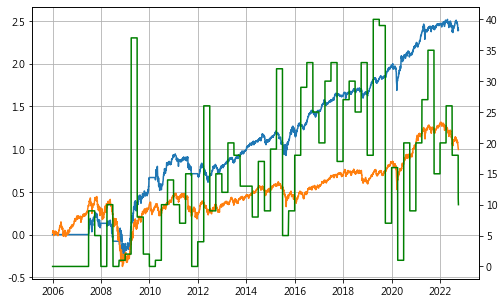

當前持倉:  {'8401': '白紗科', '2534': '宏盛', '2548': '華固', '2702': '華園', '5009': '榮剛', '2603': '長榮', '3703': '欣陸', '3376': '新日興', '8091': '翔名', '5534': '長虹'}


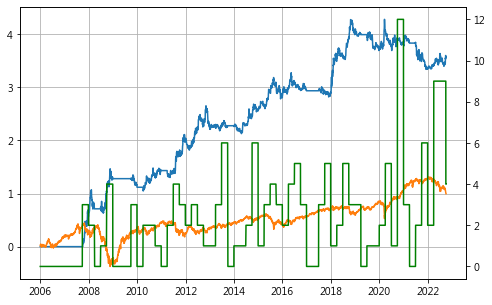

當前持倉:  {'6283': '淳安', '8440': '綠電', '3228': '金麗科', '1732': '毛寶'}
日期
2006-12-31    0.0000
2007-12-31    0.7090
2008-12-31    0.4283
2009-12-31    0.6490
2010-12-31    0.5768
2011-12-31    0.3458
2012-12-31    0.3398
2013-12-31    0.2100
2014-12-31    0.4353
2015-12-31    0.3511
2016-12-31    0.3305
2017-12-31    0.1542
2018-12-31    1.1444
2019-12-31    0.0107
2020-12-31    0.3441
2021-12-31   -0.2177
2022-12-31    0.1539
Freq: A-DEC, dtype: float64


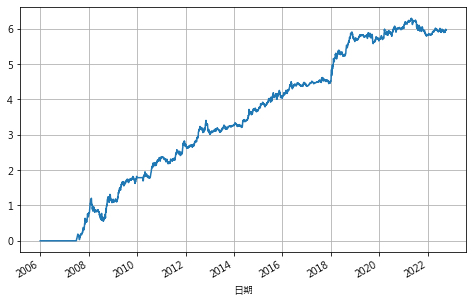

In [8]:
def 轉日資料處理(df: pd.DataFrame):
    轉日 = pd.DataFrame(index=chast.data['還原收盤價'].index, columns=chast.data['還原收盤價'].columns)
    for i in df.index:
        for c in df.columns:
            轉日.at[i, c] = df.at[i, c]
    轉日 = 轉日.sort_index().fillna(method='ffill')
    return 轉日


def 損益(轉日: pd.DataFrame, 買賣):
    大盤損益 = chast.data['大盤收盤價'].pct_change().cumsum()
    日損益 = log收盤價.shift(-1) - log收盤價
    換股日損益 = 轉日 * 日損益 * 買賣
    進場 = 轉日 - 轉日.shift(1)
    出場 = 轉日.shift(-1) - 轉日
    費用 = 轉日.copy()
    費用.iloc[:] = 0
    費用[進場 > 0] = 0.001425
    費用[出場 < 0] = 0.004425
    換股日平均損益 = (換股日損益-費用).sum(axis=1) / 轉日.sum(axis=1)
    fig, ax = plt.subplots(figsize=(8, 5))
    ax1 = ax.twinx()
    ax.plot(換股日平均損益.fillna(0).cumsum())
    ax.plot(大盤損益)
    ax1.plot(轉日.sum(axis=1), color='green')
    ax.grid(True)
    plt.show()
    print('當前持倉: ', {v: 股票名稱轉換[v] for v in 轉日.iloc[-1][轉日.iloc[-1] >= 1].index})
    return 換股日平均損益

def 損益金額(轉日: pd.DataFrame):
    持倉金額 = (轉日 * chast.data['還原收盤價'] * 1000).sum(axis=1)
    大盤損益 = (chast.data['大盤收盤價'].pct_change().mul(持倉金額, axis=0)).cumsum()
    日損益 = (chast.data['還原收盤價'].pct_change().shift(-1))
    換股日損益 = 轉日 * 日損益 * 1000
    換股日平均損益 = 換股日損益.sum(axis=1)
    fig, ax = plt.subplots(figsize=(16, 9))
    ax1 = ax.twinx()
    ax.plot(換股日平均損益.fillna(0).cumsum())
    #ax.plot(大盤損益)
    ax1.plot(轉日.sum(axis=1), color='green')
    ax.grid(True)
    plt.show()
    print('當前持倉: ', 轉日.iloc[-1][轉日.iloc[-1] >= 1].index)


轉日月末買 = 轉日資料處理(月末買)
轉日月末賣 = 轉日資料處理(月末賣)
日買平均 = 損益(轉日月末買, 1)
日賣平均 = 損益(轉日月末賣, -1)

(日買平均.fillna(0) + 日賣平均.fillna(0)).cumsum().plot(figsize=(8, 5), grid=True)#.groupby(pd.Grouper(freq='1y')).sum()
print((日買平均.fillna(0) + 日賣平均.fillna(0)).groupby(pd.Grouper(freq='1y')).sum())
plt.show()

In [9]:
# TODO: 改成多空皆有
def backtesting(per_capital: int = 750000, total_capital: int = 100000000):
    f_idx, f_col = chast.data['還原收盤價'].index, chast.data['還原收盤價'].columns
    # 製作空表格，用於計算時存值，最後set回去五個底線dataframe
    def make_df(idx, col):
        return pd.DataFrame(index=idx, columns=col)
    chast.set_data('20std', chast.data['還原收盤價'].rolling(20).std())
    
    bs = make_df(f_idx, f_col).fillna(0)
    com_ = make_df(f_idx, f_col).fillna(0)
    pf_ = make_df(f_idx, f_col).fillna(0)
    ep_ = make_df(f_idx, f_col).fillna(99999)
    ed_ = make_df(f_idx, f_col).fillna(f_idx[0])
    bs_ = make_df(f_idx, f_col).fillna(0)
    eh_ = make_df(f_idx, f_col).fillna(0)
    el_ = make_df(f_idx, f_col).fillna(99999)

    # 存前一根K的時間
    idx1 = f_idx[0]
    # 還原收盤價與收盤價的轉換
    transform = chast.data['收盤價'] / chast.data['還原收盤價']
    # 資金設定 1 億
    # per_capital = 250000
    # total_capital = 100000000
    capital = pd.Series([total_capital] * len(f_idx), index=f_idx)

    ## ----------------------------------------------------------------------------------------------------------------------------------------##
    for idx, row in chast.data['還原收盤價'].iterrows():
        # 用at取代loc，聽說更快
        for col in row.index:
            bs_.at[idx, col] = bs.at[idx1, col]
            bs.at[idx, col] = bs.at[idx1, col]
            ep_.at[idx, col] = ep_.at[idx1, col]
            eh_.at[idx, col] = eh_.at[idx1, col]
            ed_.at[idx, col] = ed_.at[idx1, col]

        capital[idx] = capital[idx1]
        
        # 進場條件1
        long_mask = (bs.loc[idx, :] <= 0) & long_entry.loc[idx, :] &\
            (chast.data['20std'].loc[idx, :] >= 0.0001) # 固有條件
        short_mask = (bs.loc[idx, :] >= 0) & short_entry.loc[idx, :] &\
            (chast.data['20std'].loc[idx, :] >= 0.0001) # 固有條件
        # 出場條件                           
        sell_mask = (bs_.loc[idx, :] > 0) & \
            (((long_entry.loc[idx, :] == False)) | (chast.data['20std'].loc[idx, :] <= 0.0001)) # 固有條件
        cover_mask = (bs_.loc[idx, :] < 0) & \
            (((short_entry.loc[idx, :] == False)) | (chast.data['20std'].loc[idx, :] <= 0.0001)) # 固有條件
        # | \ 
        #    ((chast.data['還原收盤價'].loc[idx, :] > ep_.loc[idx, :] * 1.5) | \
        #    (chast.data['還原收盤價'].loc[idx, :] < eh_.loc[idx, :] * 0.9))
        # 當有商品滿足進場條件時執行  
        if long_mask.sum() > 0:
            # 用Sharpe Ratio排序股票，作為買進順序
            for col in 優先買賣資料.loc[idx, row[long_mask].index].rank(ascending=優先買賣類型).sort_values().index:
                # 買進的股數
                contract = np.floor(per_capital / chast.data['收盤價'].at[idx, col] / 1000) * chast.data['std_level'].at[idx, col]
                # 買進花多少錢
                money = contract * 1000 * chast.data['收盤價'].at[idx, col]
                # 目前持倉多少錢
                holding = ((chast.data['收盤價'].loc[idx, :] * bs.loc[idx, :]) * 1000).sum()
                # 若資金足夠、持倉市值沒太大才買進
                if (capital.at[idx] > money) & (holding < total_capital) & (contract >= 1):
                    bs.at[idx, col] = contract
                    capital.at[idx] -= money
                else:
                    pass
        if short_mask.sum() > 0:
            for col in 優先買賣資料.loc[idx, row[short_mask].index].rank(ascending=優先買賣類型).sort_values().index:
                # 買進的股數
                contract = np.floor(per_capital / chast.data['收盤價'].at[idx, col] / 1000) * chast.data['std_level'].at[idx, col]
                # 買進花多少錢
                money = contract * 1000 * chast.data['收盤價'].at[idx, col]
                # 目前持倉多少錢
                holding = ((chast.data['收盤價'].loc[idx, :] * bs.loc[idx, :]) * 1000).sum()
                # 若資金足夠、持倉市值沒太大才買進
                if (capital.at[idx] > money) & (holding < total_capital) & (contract >= 1):
                    bs.at[idx, col] = -contract
                    capital.at[idx] -= money
                else:
                    pass
        # 當有商品滿足出場條件時執行
        if sell_mask.sum() > 0:
            for col in row[sell_mask].index:
                money = bs_.at[idx, col] * 1000 * chast.data['收盤價'].at[idx, col]
                a = capital.at[idx]
                capital.at[idx] += money
                if bs.at[idx, col] > 0:
                    bs.at[idx, col] = 0
        if cover_mask.sum() > 0:
            for col in row[cover_mask].index:
                money = abs(bs_.at[idx, col]) * 1000 * chast.data['收盤價'].at[idx, col]
                a = capital.at[idx]
                capital.at[idx] += money
                if bs.at[idx, col] < 0:
                    bs.at[idx, col] = 0
        for col in row.index:
            # 多單進場
            if (bs_.at[idx, col] >= 1) & (bs_.at[idx1, col] <= 0):
                com_.at[idx, col] += np.round((0.001425 + 0.003) * bs_.at[idx, col] * 1000 * chast.data['收盤價'].at[idx, col], 2)
                ep_.at[idx, col] = chast.data['還原收盤價'].at[idx, col]
                eh_.at[idx, col] = chast.data['還原收盤價'].at[idx, col]
                el_.at[idx, col] = chast.data['還原收盤價'].at[idx, col]
                ed_.at[idx, col] = idx
            # 多單出場   
            if (bs_.at[idx, col] <= 0) & (bs_.at[idx1, col] >= 1):
                com_.at[idx, col] += np.round((0.001425 + 0.003 + 0.003) * abs(bs_.at[idx1, col]) * 1000 * chast.data['收盤價'].at[idx, col], 2)

            # 空單進場
            if (bs_.at[idx, col] <= -1) & (bs_.at[idx1, col] >= 0):
                com_.at[idx, col] += np.round((0.001425 + 0.003) * abs(bs_.at[idx, col]) * 1000 * chast.data['收盤價'].at[idx, col], 2)
                ep_.at[idx, col] = chast.data['還原收盤價'].at[idx, col]
                eh_.at[idx, col] = chast.data['還原收盤價'].at[idx, col]
                el_.at[idx, col] = chast.data['還原收盤價'].at[idx, col]
                ed_.at[idx, col] = idx
            # 空單出場   
            if (bs_.at[idx, col] >= 0) & (bs_.at[idx1, col] <= -1):
                com_.at[idx, col] += np.round((0.001425 + 0.003 + 0.003) * abs(bs_.at[idx1, col]) * 1000 * chast.data['收盤價'].at[idx, col], 2)
            
            # 損益計算
            if (bs_.at[idx1, col] != 0):
                pf_.at[idx, col] = np.round((chast.data['還原收盤價'].at[idx, col] - chast.data['還原收盤價'].at[idx1, col]) * transform.at[idx1, col] * bs_.at[idx1, col] * 1000, 2)
                if chast.data['還原收盤價'].at[idx, col] > eh_.at[idx, col]:
                    eh_.at[idx, col] = chast.data['還原收盤價'].at[idx, col]
                if chast.data['還原收盤價'].at[idx, col] < el_.at[idx, col]:
                    el_.at[idx, col] = chast.data['還原收盤價'].at[idx, col]
        
        idx1 = idx
    ## ----------------------------------------------------------------------------------------------------------------------------------------##
    chast.set_result(pf_, bs_, com_, ep_, ed_, capital)
    chast.get_chart()



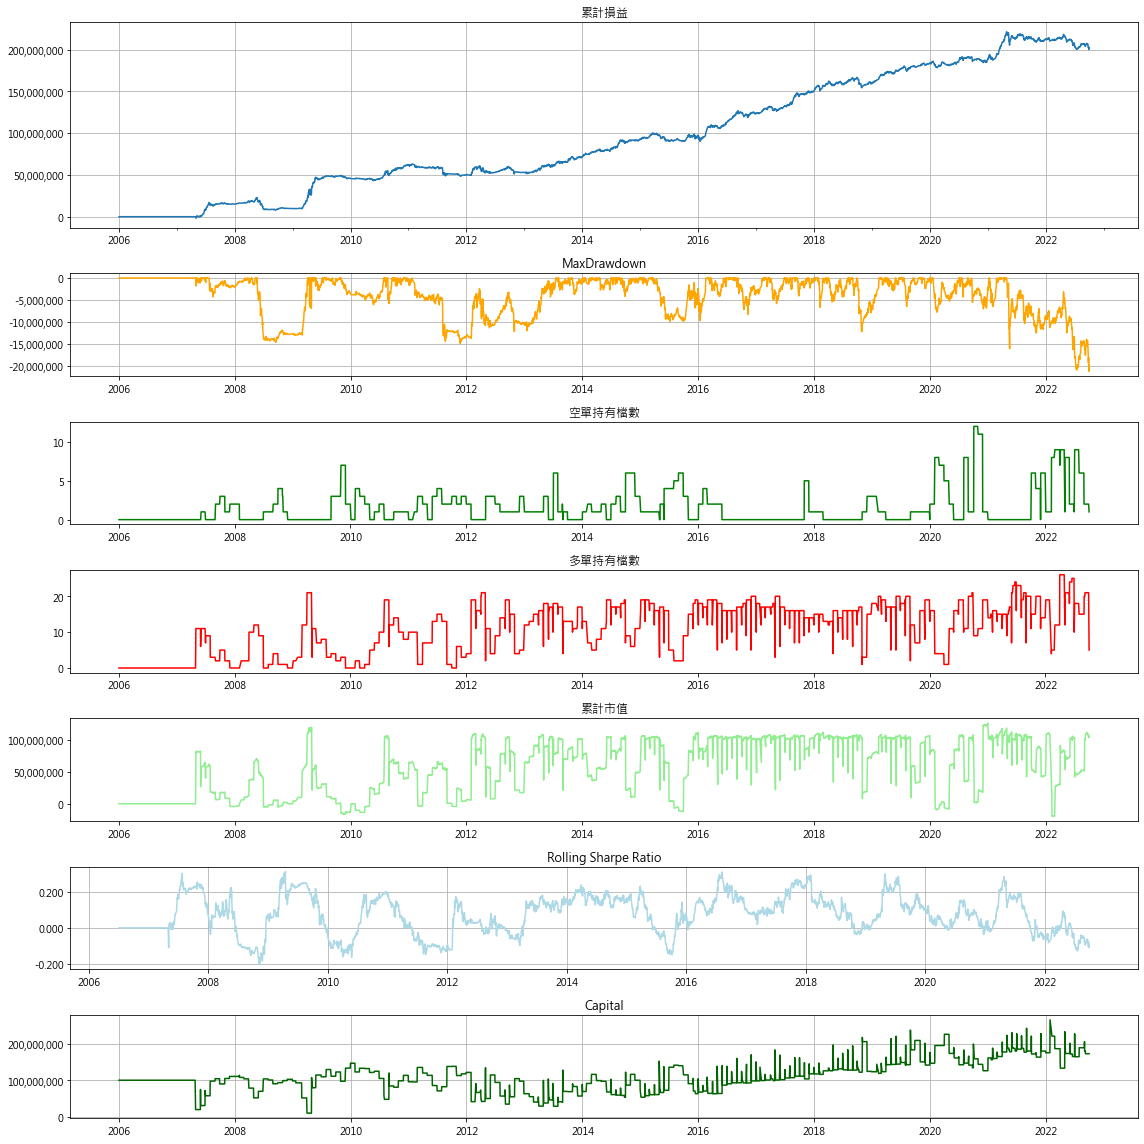

In [10]:
月末 = long.groupby(pd.Grouper(freq='m')).tail(1)
月末賣 = short.groupby(pd.Grouper(freq='m')).tail(1)
# 設定以下四個資料就可以回測
long_entry = 轉日資料處理(月末) # index = datetime.datetime: 日, columns = stock_id: 內容為"持倉 = 1" 或者"無持倉 = 0"
short_entry = 轉日資料處理(月末賣) # index = datetime.datetime: 日, columns = stock_id: 內容為"持倉 = 1" 或者"無持倉 = 0"
優先買賣資料 = chast.data['股價淨值比']; 優先買賣類型 = True # 當資金不足時以什麼為先後買賣判斷順序，True為先買低先賣高，False為先買高先賣低
# std_level 用於調整在不同std的買進倍數，波動越大買越少(差距10倍)
std_level = chast.data['還原收盤價'].pct_change().rolling(20).std().div(chast.data['還原收盤價'].pct_change().std(axis=1), axis=0).replace([np.inf, -np.inf], 1)
for i, v in std_level.iterrows():
    # 去除極端值
    v99 = v.quantile(.95)
    v01 = v.quantile(.05)
    mask_99 = v[v > v99].index
    mask_01 = v[v < v01].index
    std_level.loc[i, mask_99] = v99
    std_level.loc[i, mask_01] = v01
# 把股票按照波動排名，後續用作買的倍率[5, 4, 3, 2, 1]
std_level = std_level.apply(lambda x: pd.cut(x, bins=5, labels=[10, 7, 4, 2 ,1]) if x.sum() != 0 else [0] * len(x), axis=0)
backtesting()